In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sagemaker
import boto3
import io
import sagemaker.amazon.common as smac
import os
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

In [4]:
data = pd.read_csv('FuelEconomy.csv')
data.head()

,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739


In [5]:
X = data['Horse Power']
y = data['Fuel Economy (MPG)']

In [6]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1))

In [9]:
sagemaker_session = sagemaker.Session()

bucket = 'sagemaker-mpg'
prefix = 'linear_learner'

role = sagemaker.get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
arn:aws:iam::809503251832:role/Sagemaker_ML_Engineer


In [10]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 

key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-mpg/linear_learner/train/linear-train-data


In [11]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 

key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://sagemaker-mpg/linear_learner/test/linear-test-data


In [12]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-mpg/linear_learner/output


In [13]:
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [14]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       use_spot_instances = True,
                                       max_wait = 300,
                                       max_run = 60,
                                       sagemaker_session = sagemaker_session)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-27-21-06-34-580


2023-11-27 21:06:34 Starting - Starting the training job...
2023-11-27 21:07:02 Starting - Preparing the instances for training............
2023-11-27 21:08:45 Downloading - Downloading input data...
2023-11-27 21:09:26 Training - Downloading the training image......
2023-11-27 21:10:36 Training - Training image download completed. Training in progress....
2023-11-27 21:11:07 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[11/27/2023 21:10:54 INFO 140008149247808] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07

In [15]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2023-11-27-21-11-48-501
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-11-27-21-11-48-501
INFO:sagemaker:Creating endpoint with name linear-learner-2023-11-27-21-11-48-501


-------!

In [16]:
result = linear_regressor.predict(X_test)

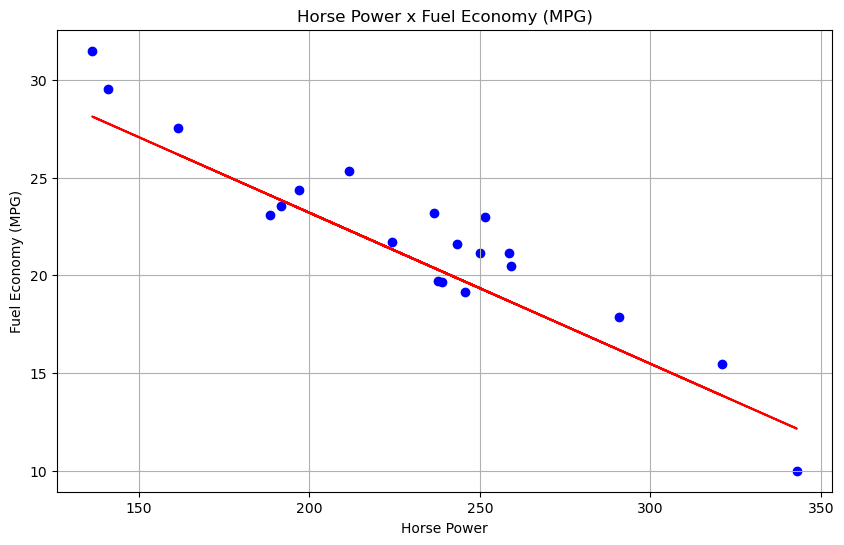

In [17]:
predictions = np.array([r['score'] for r in result['predictions']])

# VISUALIZE TEST SET RESULTS
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Horse Power')
plt.ylabel('Fuel Economy (MPG)')
plt.title('Horse Power x Fuel Economy (MPG)')
plt.grid()

In [18]:
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-11-27-21-11-48-501
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-11-27-21-11-48-501
